# 1. モジュールインポート

In [2]:
import pandas as pd
import glob
import os
from tqdm.notebook import tqdm

from modules.constants import LocalDirs
from modules import preparing
from modules import preprocessing
from modules import training
from modules import simulation
from modules import policies
%load_ext autoreload

# 2. データ取得
例として、2021年のレースデータを取得する場合を考える

## 2.1. レースID取得

In [2]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2021 = preparing.scrape_kaisai_date(from_="2021-01-01", to_="2022-01-01")
len(kaisai_date_2021)

getting race date from 2021-01-01 to 2022-01-01


  0%|          | 0/12 [00:00<?, ?it/s]

106

In [4]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2021)
len(race_id_list)

getting race_id_list


  0%|          | 0/3 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20210105
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20210109
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20210110


72

## 2.2. /race/ディレクトリのデータ取得

In [7]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=True)
html_files_race[:5]

  0%|          | 0/10 [00:00<?, ?it/s]

race_id 202106010101 skipped
race_id 202106010102 skipped
race_id 202106010103 skipped
race_id 202106010104 skipped
race_id 202106010105 skipped
race_id 202106010106 skipped
race_id 202106010107 skipped
race_id 202106010108 skipped
race_id 202106010109 skipped
race_id 202106010110 skipped


['/Users/chiyoda/Documents/readers-repo/data/html/race/202106010101.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010102.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010103.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010104.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010105.bin']

In [8]:
results = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_table = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [100]:
#保存
results.to_pickle('data/raw/results/results_2021.pickle')
race_info.to_pickle('data/raw/race_info/race_info_2021.pickle')
return_table.to_pickle('data/raw/return_tables/return_tables_2021.pickle')

## 2.3. /horse/ディレクトリのデータ取得

In [15]:
horse_id_list = results['horse_id'].unique()
html_files_horse = preparing.scrape_html_horse(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/5 [00:00<?, ?it/s]

horse_id 2018106541 skipped
horse_id 2018103708 skipped
horse_id 2018103805 skipped
horse_id 2018101171 skipped


In [18]:
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalDirs.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]

  0%|          | 0/5 [00:00<?, ?it/s]

['/Users/chiyoda/Documents/readers-repo/data/html/horse/2018106541.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/horse/2018103708.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/horse/2018103805.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/horse/2018101171.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/horse/2018103832.bin']

In [19]:
horse_results_2021 = preparing.get_rawdata_horse_results(html_files_horse) #馬の過去成績テーブルの作成
horse_results_2021.to_pickle('data/raw/horse_results/horse_results_2021.pickle')

  0%|          | 0/5 [00:00<?, ?it/s]

## 2.4. /ped/ディレクトリのデータ取得

In [20]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
peds_2021 = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
peds_2021.to_pickle('data/raw/peds/peds_2021.pickle')

  0%|          | 0/5 [00:00<?, ?it/s]

# 3. データ加工

In [83]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。
%autoreload

In [3]:
#rawデータファイルパスの取得
files_results = glob.glob(os.path.join(LocalDirs.RAW_RESULTS_DIR, '*.pickle'))
files_race_info = glob.glob(os.path.join(LocalDirs.RAW_RACE_INFO_DIR, '*.pickle'))
files_return = glob.glob(os.path.join(LocalDirs.RAW_RETURN_DIR, '*.pickle'))
files_horse_results = glob.glob(os.path.join(LocalDirs.RAW_HORSE_RESULTS_DIR, '*.pickle'))
files_peds = glob.glob(os.path.join(LocalDirs.RAW_PEDS_DIR, '*.pickle'))

In [4]:
#前処理
results_processor = preprocessing.ResultsProcessor(files_results)
race_info_processor = preprocessing.RaceInfoProcessor(files_race_info)
return_processor = preprocessing.ReturnProcessor(files_return)
horse_results_processor = preprocessing.HorseResultsProcessor(files_horse_results)
peds_processor = preprocessing.PedsProcessor(files_peds)

In [6]:
### 馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理 ###

#ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = ['着順', '賞金', '着差', 'first_corner', 'final_corner',
               'first_to_rank', 'first_to_final','final_to_rank']
#horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = ['course_len', 'race_type', '開催']

data_merger = preprocessing.DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
data_merger.merge() #処理実行

separating horse results by date


  0%|          | 0/106 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/106 [00:00<?, ?it/s]

In [7]:
#カテゴリ変数の処理
feature_enginnering = preprocessing.FeatureEngineering(data_merger)\
    .add_interval()\
        .dumminize_ground_state()\
            .dumminize_race_type()\
                .dumminize_sex()\
                    .dumminize_weather()\
                        .encode_horse_id()\
                            .encode_jockey_id()\
                                .dumminize_kaisai()

In [26]:
#保存
#tmpは一時保存用のディレクトリ
feature_enginnering.featured_data.to_pickle('data/tmp/featured_data_2021.pickle')

# 4. 学習

In [27]:
keiba_ai = training.KeibaAIFactory.create(feature_enginnering.featured_data) #モデル作成
keiba_ai.train_with_tuning() #パラメータチューニングをして学習

[I 2022-06-15 19:51:06,339] A new study created in memory with name: no-name-1a12fe30-a4fc-4b92-9daf-67a3e775221e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.505442:  14%|#4        | 1/7 [00:01<00:08,  1.48s/it]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.412672	valid_1's binary_logloss: 0.505442
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.504646:  29%|##8       | 2/7 [00:02<00:05,  1.19s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.428028	valid_1's binary_logloss: 0.504646
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.504646:  43%|####2     | 3/7 [00:03<00:04,  1.01s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.437944	valid_1's binary_logloss: 0.506264
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.504646:  57%|#####7    | 4/7 [00:03<00:02,  1.14it/s]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.439497	valid_1's binary_logloss: 0.506817
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.504646:  71%|#######1  | 5/7 [00:04<00:01,  1.17it/s]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.428785	valid_1's binary_logloss: 0.507668
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.504646:  86%|########5 | 6/7 [00:05<00:00,  1.23it/s]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.434306	valid_1's binary_logloss: 0.50721
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.504646: 100%|##########| 7/7 [00:06<00:00,  1.09it/s]


Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.423502	valid_1's binary_logloss: 0.506969


num_leaves, val_score: 0.504646:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.504646:   5%|5         | 1/20 [00:01<00:35,  1.89s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.35361	valid_1's binary_logloss: 0.505989
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.504646:  10%|#         | 2/20 [00:03<00:29,  1.66s/it]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.387733	valid_1's binary_logloss: 0.504764
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.504646:  15%|#5        | 3/20 [00:05<00:27,  1.64s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.367983	valid_1's binary_logloss: 0.506195
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.504646:  20%|##        | 4/20 [00:07<00:28,  1.80s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.346589	valid_1's binary_logloss: 0.509027
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.504646:  25%|##5       | 5/20 [00:07<00:20,  1.35s/it]

Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.4778	valid_1's binary_logloss: 0.511909
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  30%|###       | 6/20 [00:08<00:17,  1.28s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412586	valid_1's binary_logloss: 0.503955
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  35%|###5      | 7/20 [00:10<00:19,  1.54s/it]

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.34718	valid_1's binary_logloss: 0.5073
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  40%|####      | 8/20 [00:13<00:22,  1.85s/it]

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.328356	valid_1's binary_logloss: 0.509589
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  45%|####5     | 9/20 [00:14<00:17,  1.59s/it]

Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.429678	valid_1's binary_logloss: 0.505982
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  50%|#####     | 10/20 [00:16<00:16,  1.63s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.372636	valid_1's binary_logloss: 0.507301
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  55%|#####5    | 11/20 [00:17<00:13,  1.50s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.401441	valid_1's binary_logloss: 0.506123
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  60%|######    | 12/20 [00:18<00:12,  1.50s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.388999	valid_1's binary_logloss: 0.504366
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  65%|######5   | 13/20 [00:20<00:10,  1.45s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.38888	valid_1's binary_logloss: 0.506845
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  70%|#######   | 14/20 [00:20<00:07,  1.27s/it]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.432855	valid_1's binary_logloss: 0.506574
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  75%|#######5  | 15/20 [00:22<00:06,  1.21s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.424164	valid_1's binary_logloss: 0.504802
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  80%|########  | 16/20 [00:23<00:05,  1.31s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.377313	valid_1's binary_logloss: 0.504145
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  85%|########5 | 17/20 [00:25<00:04,  1.37s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.377121	valid_1's binary_logloss: 0.504045
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  90%|######### | 18/20 [00:27<00:03,  1.53s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.34301	valid_1's binary_logloss: 0.50858
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955:  95%|#########5| 19/20 [00:28<00:01,  1.54s/it]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.350957	valid_1's binary_logloss: 0.505922
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.503955: 100%|##########| 20/20 [00:30<00:00,  1.50s/it]


Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.367983	valid_1's binary_logloss: 0.506195


bagging, val_score: 0.503955:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  10%|#         | 1/10 [00:00<00:08,  1.07it/s]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.419583	valid_1's binary_logloss: 0.507592
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  20%|##        | 2/10 [00:01<00:06,  1.27it/s]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.445425	valid_1's binary_logloss: 0.508734
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  30%|###       | 3/10 [00:03<00:07,  1.09s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.415971	valid_1's binary_logloss: 0.510973
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  40%|####      | 4/10 [00:04<00:06,  1.13s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.420739	valid_1's binary_logloss: 0.507278
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  50%|#####     | 5/10 [00:05<00:04,  1.01it/s]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.450174	valid_1's binary_logloss: 0.508411
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  60%|######    | 6/10 [00:06<00:04,  1.05s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.416891	valid_1's binary_logloss: 0.505742
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  70%|#######   | 7/10 [00:06<00:02,  1.11it/s]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.459349	valid_1's binary_logloss: 0.51217
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  80%|########  | 8/10 [00:07<00:01,  1.16it/s]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.440933	valid_1's binary_logloss: 0.50918
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955:  90%|######### | 9/10 [00:08<00:00,  1.03it/s]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.41759	valid_1's binary_logloss: 0.505713
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.503955: 100%|##########| 10/10 [00:09<00:00,  1.02it/s]


Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.420125	valid_1's binary_logloss: 0.506252


feature_fraction_stage2, val_score: 0.503955:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.503955:  17%|#6        | 1/6 [00:00<00:04,  1.02it/s]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.417382	valid_1's binary_logloss: 0.504868
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.503955:  33%|###3      | 2/6 [00:01<00:03,  1.06it/s]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.419383	valid_1's binary_logloss: 0.506178
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.503955:  50%|#####     | 3/6 [00:02<00:03,  1.01s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.40693	valid_1's binary_logloss: 0.504415
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.503955:  67%|######6   | 4/6 [00:03<00:01,  1.07it/s]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.433	valid_1's binary_logloss: 0.505247
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.503955:  83%|########3 | 5/6 [00:04<00:00,  1.00it/s]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412987	valid_1's binary_logloss: 0.505311
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.503955: 100%|##########| 6/6 [00:06<00:00,  1.01s/it]


Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.417529	valid_1's binary_logloss: 0.506209


regularization_factors, val_score: 0.503955:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:   5%|5         | 1/20 [00:01<00:24,  1.27s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412589	valid_1's binary_logloss: 0.503935
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  10%|#         | 2/20 [00:02<00:27,  1.52s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.426226	valid_1's binary_logloss: 0.50681
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  15%|#5        | 3/20 [00:04<00:25,  1.47s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412586	valid_1's binary_logloss: 0.503954
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  20%|##        | 4/20 [00:05<00:22,  1.39s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.413652	valid_1's binary_logloss: 0.504995
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  25%|##5       | 5/20 [00:06<00:19,  1.27s/it]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.43188	valid_1's binary_logloss: 0.504502
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  30%|###       | 6/20 [00:08<00:18,  1.29s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.429631	valid_1's binary_logloss: 0.505386
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  35%|###5      | 7/20 [00:09<00:16,  1.27s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412586	valid_1's binary_logloss: 0.503939
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  40%|####      | 8/20 [00:10<00:14,  1.22s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.433676	valid_1's binary_logloss: 0.505918
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  45%|####5     | 9/20 [00:11<00:14,  1.28s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.397497	valid_1's binary_logloss: 0.504069
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  50%|#####     | 10/20 [00:12<00:11,  1.19s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.426815	valid_1's binary_logloss: 0.504933
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  55%|#####5    | 11/20 [00:13<00:10,  1.17s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.41259	valid_1's binary_logloss: 0.503939
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  60%|######    | 12/20 [00:15<00:09,  1.17s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412588	valid_1's binary_logloss: 0.503955
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  65%|######5   | 13/20 [00:16<00:08,  1.18s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412588	valid_1's binary_logloss: 0.503939
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  70%|#######   | 14/20 [00:17<00:06,  1.14s/it]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.431884	valid_1's binary_logloss: 0.504516
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  75%|#######5  | 15/20 [00:18<00:05,  1.18s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.415887	valid_1's binary_logloss: 0.504673
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  80%|########  | 16/20 [00:19<00:04,  1.21s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.430327	valid_1's binary_logloss: 0.505645
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  85%|########5 | 17/20 [00:20<00:03,  1.16s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.43036	valid_1's binary_logloss: 0.505336
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  90%|######### | 18/20 [00:22<00:02,  1.31s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.415911	valid_1's binary_logloss: 0.504195
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935:  95%|#########5| 19/20 [00:23<00:01,  1.33s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.412533	valid_1's binary_logloss: 0.50409
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.503935: 100%|##########| 20/20 [00:25<00:00,  1.25s/it]


Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.429305	valid_1's binary_logloss: 0.505251


min_data_in_leaf, val_score: 0.503935:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.503935:  20%|##        | 1/5 [00:00<00:03,  1.04it/s]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.42921	valid_1's binary_logloss: 0.504665
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.503935:  40%|####      | 2/5 [00:02<00:03,  1.04s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.417611	valid_1's binary_logloss: 0.506102
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.503935:  60%|######    | 3/5 [00:03<00:02,  1.00s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.437382	valid_1's binary_logloss: 0.505507
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.503935:  80%|########  | 4/5 [00:04<00:01,  1.05s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.419106	valid_1's binary_logloss: 0.506311
[LightGBM] [Info] Number of positive: 5073, number of negative: 18322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29799
[LightGBM] [Info] Number of data points in the train set: 23395, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216841 -> initscore=-1.284170
[LightGBM] [Info] Start training from score -1.284170
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.503935: 100%|##########| 5/5 [00:05<00:00,  1.03s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.423682	valid_1's binary_logloss: 0.505869
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l1 is set=0.0007773998922821829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007773998922821829
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=3.2012859298995277e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2012859298995277e-06


AUC: 0.848(train), 0.642(test)


In [28]:
#特徴量の重要度
keiba_ai.feature_importance()

,features,importance
4,jockey_id,171
6,体重,120
168,interval,88
8,n_horses,87
7,体重変化,58
3,horse_id,57
11,賞金_5R,56
5,年齢,50
26,着順_race_type_5R,49
2,斤量,46


In [29]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 33,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_pre_filter': False,
 'lambda_l1': 0.0007773998922821829,
 'lambda_l2': 3.2012859298995277e-06,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0}

In [26]:
#チューニングしないで学習
#keiba_ai.train_without_tuning()

AUC: 0.826(train), 0.648(test)


In [287]:
#モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
training.KeibaAIFactory.save(keiba_ai, version_name='testmodel_2021')

In [87]:
#モデルロード
loaded_ai = training.KeibaAIFactory.load('models/20220602/testmodel_2021.pickle')
loaded_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [217]:
%autoreload

In [30]:
#シミュレーターに馬券をセット
simulator = simulation.Simulator(return_processor)

## 5.1. 単一threshold

In [31]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1-(i/N_SAMPLES))
    try:
        #賭ける馬券を決定
        actions = keiba_ai.decide_action(
                keiba_ai.datasets.X_test, #テストデータ
                policies.StdScorePolicy, #「馬の勝ちやすさ」スコアを決める方針
                policies.BetPolicyTansho, #賭け方の方針
                threshold=threshold #「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

  0%|          | 0/100 [00:00<?, ?it/s]

In [291]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220602/tansho.pickle')

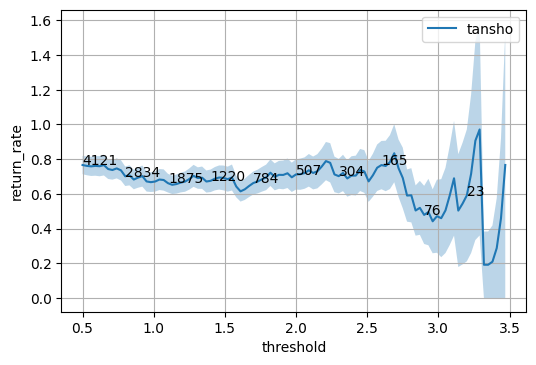

In [32]:
#回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='tansho')

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [274]:
T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1-(i/N_SAMPLES))
    for j in range(N_SAMPLES):
        #MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1-(j/N_SAMPLES))
        try:
            #print(threshold1, threshold2)
            #賭ける馬券を決定
            actions = keiba_ai.decide_action(
                    keiba_ai.datasets.X_test, #テストデータ
                    policies.StdScorePolicy, #「馬の勝ちやすさ」スコアを決める方針
                    policies.BetPolicyTanshoFukusho, #賭け方の方針(未実装)
                    threshold1=threshold1, #「馬の勝ちやすさスコア」の閾値
                    threshold2=threshold2
                    )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient='index')

  0%|          | 0/10 [00:00<?, ?it/s]

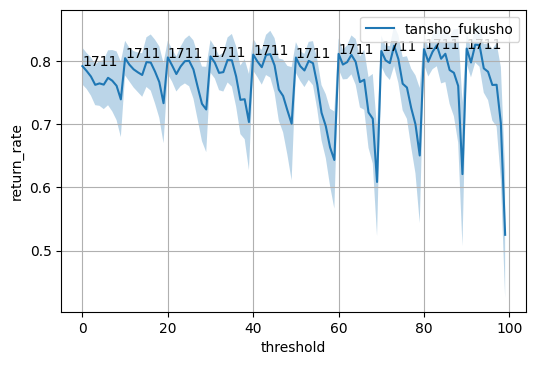

In [273]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [36]:
%autoreload

In [34]:
race_id_list = preparing.scrape_race_id_list(['20220108']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108


24

In [37]:
update_horse = preparing.UpdateHorse()
horse_id_list = update_horse.scrape_horse_id_list(race_id_list) #当日出走する馬一覧を取得
#馬の過去成績を更新し、data/raw/horse_results_(スクレイピングした日付).pickleに保存する。
update_horse.update_horse_results(horse_id_list)
#血統データを更新し、data/raw/peds_(スクレイピングした日付).pickleに保存する。
update_horse.update_peds(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

scraping horse_results


  0%|          | 0/361 [00:00<?, ?it/s]

preparing raw horse_results table


  0%|          | 0/361 [00:00<?, ?it/s]

scraping peds


  0%|          | 0/361 [00:00<?, ?it/s]

preparing raw peds table


  0%|          | 0/361 [00:00<?, ?it/s]

In [38]:
#出走する馬の過去成績の加工
horse_results_processor_shutuba = preprocessing.HorseResultsProcessor([update_horse.horse_results_path])
#出走する馬の血統テーブルの加工
peds_processor_shutuba = preprocessing.PedsProcessor([update_horse.peds_path])

In [32]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20220602/testmodel_2021.pickle')

## 6.2. レース直前データ取得

In [39]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2022/1/8', filepath) #出馬表の取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [40]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor_shutuba,
    peds_processor_shutuba,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
        .dumminize_ground_state()\
            .dumminize_race_type()\
                .dumminize_sex()\
                    .dumminize_weather()\
                        .encode_horse_id()\
                            .encode_jockey_id()\
                                .dumminize_kaisai()

In [42]:
#予測
X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)
keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False)

,馬番,単勝,score
202206010201,3,4.3,2.274956
202206010201,5,4.7,1.205645
202206010201,11,5.4,1.169763
202206010201,15,4.5,1.068296
202206010201,16,14.2,0.678975
202206010201,4,5.7,0.475609
202206010201,6,16.9,0.375901
202206010201,9,101.3,-0.562297
202206010201,7,177.8,-0.684012
202206010201,13,29.8,-0.708120
